In [11]:
import os
from itertools import islice

import numpy as np
import pandas as pd

from skimage.external import tifffile
from scipy.ndimage import gaussian_filter
from skimage.external.tifffile import imread


import ipywidgets as widgets

from scipy import ndimage
from PIL import Image, ImageDraw

import numpy.ma as ma

from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

In [2]:
bigDir = r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\DATA'

In [3]:
myFile= r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\sel_cells_20_50_10.csv'

In [4]:
myBigData=pd.read_csv(myFile)

In [5]:
myBigData['exp_folder']='-'

In [6]:
for i, cell in myBigData.iterrows():
    myBigData.loc[i, 'path']=myBigData.loc[i, 'path'].replace('S:', 'Z:')
    myBigData.loc[i, 'exp_folder']=myBigData.loc[i, 'path'].split('DATA\\')[1].split('\data')[0]

In [7]:
myBigData.head()

,Unnamed: 0,Unnamed: 0.1,file,original cell name,Amy_mod,movie,x,y,ab1 (heterochromatin),ab1 ch,...,random_50perc_ch3,hetChrom_10_volume,random_10_volume,hetChrom_10perc_ch1,random_10perc_ch1,hetChrom_10perc_ch2,random_10perc_ch2,hetChrom_10perc_ch3,random_10perc_ch3,exp_folder
0,0,0,20190625_cell-00.czi,7LE1(B),1130/10,190619-cdc6-dhb-pcna002xy09,172,956,HP1B,1,...,5183895648,45987.0,46247.0,6.366278e+08,281528813.0,174067475.0,131640512.0,1.352231e+09,1.043517e+09,20190625-MSL rename
1,1,1,20190625_cell-01.czi,7L-E1(T),0,190619-cdc6-dhb-pcna002xy09,158,906,HP1B,1,...,5288437819,43651.0,43924.0,5.861875e+08,266516067.0,162411790.0,128299406.0,1.353023e+09,1.065184e+09,20190625-MSL rename
2,2,2,20190625_cell-02.czi,7L-E2(B),0,190619-cdc6-dhb-pcna002xy09,832,252,HP1B,1,...,5581327341,39698.0,39812.0,6.928624e+08,318905411.0,194622718.0,148176740.0,1.366670e+09,1.118365e+09,20190625-MSL rename
3,3,3,20190625_cell-03.czi,7L-E2(T),0,190619-cdc6-dhb-pcna002xy09,888,160,HP1B,1,...,5249713037,42159.0,41848.0,6.473978e+08,285348983.0,195376713.0,139563277.0,1.298882e+09,1.038559e+09,20190625-MSL rename
4,4,4,20190625_cell-05.czi,7L-G2,0,190619-cdc6-dhb-pcna002xy09,172,324,HP1B,1,...,10797892218,81411.0,81271.0,1.506281e+09,698512214.0,248463390.0,183210463.0,2.583220e+09,2.158853e+09,20190625-MSL rename


In [8]:
weird=[]

In [9]:
myBigData['box_mask_volume']=None
myBigData['box_mask_nuc']=None
myBigData['box_mask_het']=None

In [19]:
i=0

# Progress Bar
progBar=widgets.IntProgress(
    value=i,
    min=0,
    max=len(myBigData),
    step=1,
    description='Progress:',
    orientation='horizontal'
)
display(progBar)

for i, cell in myBigData.iterrows():
    percentile = 10

    # open tiff image of a cell
    myImage=imread(cell.path)    
    myChannel = myImage[:, 0, :, :] #1st channel is hetChrom (as stained by HP1B or H3K9Me3)

    # open nucleus mask
    nucleusMaskPath=cell.path
    nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
    nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
    nucMask=imread(nucleusMaskPath)
    nucMask=nucMask.astype(bool)

    # open het mask - new control
    myHetMaskPath=cell.path
    myHetMaskPath=myHetMaskPath.replace('data_tiff',f'segmentation_{percentile}')
    myHetMaskPath=myHetMaskPath.replace('.tif','_hetChrom.tif')
    het=imread(myHetMaskPath)
    het=het.astype(bool)
        
    nucMask[nucMask==255]=1

    ## finding box boundary

    z_axis=np.argmax(nucMask,axis=0)
    t=label(z_axis>0)
    props=regionprops(t)
    prop=props[0].bbox

    x_min = prop[0]
    x_max = prop[2]
    y_min = prop[1]
    y_max = prop[3]

    y_axis=np.argmax(nucMask,axis=2)
    t=label(y_axis>0)
    props=regionprops(t)
    prop=props[0].bbox

    z_min = prop[0]
    z_max = prop[2]

    nucMask_with_cube=ma.zeros(nucMask.shape)
    nucMask_with_cube=nucMask_with_cube.astype(bool)
    nucMask_with_cube[z_min:z_max, x_min:x_max, y_min:y_max]=1
    product_nucMask_nucCube=np.bitwise_and(nucMask,nucMask_with_cube)


    ## filling the box

    while(np.sum(product_nucMask_nucCube) < np.sum(nucMask_with_cube)):

        x_min+=10
        x_max-=10
        y_min+=10
        y_max-=10
        z_min+=1
        z_max-=1

        nucMask_with_cube=ma.zeros(nucMask_with_cube.shape)
        nucMask_with_cube[z_min:z_max, x_min:x_max, y_min:y_max]=1
        nucMask_with_cube=nucMask_with_cube.astype(bool)
        product_nucMask_nucCube=np.bitwise_and(nucMask,nucMask_with_cube)

    ## masking heterochromatin with the box-mask

    nucMask_with_cube_copy=nucMask_with_cube.copy()
    nucMask_with_cube_copy=nucMask_with_cube_copy.astype(int)
    het_copy=het.copy()
    het_copy=het_copy.astype(int)
    het_box_mask=het_copy[z_min:z_max, x_min:x_max, y_min:y_max]
    het_mask_with_box=ma.zeros(het_copy.shape)
    het_mask_with_box[z_min:z_max, x_min:x_max, y_min:y_max]=het_box_mask

    ## reversing masked heterochromatin

    test_new=het_mask_with_box.copy()
    het_reverse = test_new[::-1,::-1,::-1]
    z_axis=np.argmax(het_reverse,axis=0)
    t=label(z_axis>0)
    props=regionprops(t)
    if (len(props)==0):
        weird.append(cell.path)
    else:
        prop=props[0].bbox

        x_min = prop[0]
        x_max = prop[2]
        y_min = prop[1]
        y_max = prop[3]

        y_axis=np.argmax(het_reverse,axis=2)
        t=label(y_axis>0)
        props=regionprops(t)
        prop=props[0].bbox

        z_min = prop[0]
        z_max = prop[2]

        het_box_reversed=het_reverse[z_min:z_max, x_min:x_max, y_min:y_max]

        ## "tiling" heterochromatin box


        z_rep=int(het.shape[0]/het_box_reversed.shape[0])
        x_rep=int(het.shape[1]/het_box_reversed.shape[1])
        y_rep=int(het.shape[2]/het_box_reversed.shape[2])


        het_tiled_with_box = np.tile(het_box_reversed, (z_rep, x_rep, y_rep) )

        ### re-shaping the image 

        het_final_box=ma.zeros(nucMask_with_cube.shape)

        het_final_box.shape

        het_final_box[0:het_tiled_with_box.shape[0], 0:het_tiled_with_box.shape[1], 0:het_tiled_with_box.shape[2]]=het_tiled_with_box


        het_final_box=het_final_box.astype(bool)

        nucMask=nucMask.astype(bool)

        nucMask[het_final_box]=0

        het_masked_final=nucMask.copy()


        newSegFolder = os.path.dirname(cell.path).replace('data_tiff','mask_box_method_10')

        try:
            os.mkdir(newSegFolder)
        except:
            pass

        maskFile = os.path.basename(cell.path).replace('.tif',f'_box_mask_{percentile}.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), het_masked_final.astype('uint8'))

        x=het_final_box.shape[0]
        y=het_final_box.shape[1]
        z=het_final_box.shape[2]

        myBigData.at[i,'box_mask_volume']=x*y*z

        myBigData.at[i,'box_mask_nuc_box']=np.sum(nucMask_with_cube)
        myBigData.at[i,'box_mask_het']=np.sum(het_final_box)

    
        # calculate signals
        
        het_masked_final=het_masked_final.astype(bool)
        # calculate signals
        df = pd.DataFrame(columns = [f'HetChrom_newctl_{percentile}_Volume',f'HetChrom_newctl_{percentile}_ch1',f'HetChrom_newctl_{percentile}_ch2',f'HetChrom_newctl_{percentile}_ch3'])

        df.Slice = range(myChannel.shape[0])
        df.HetChrom_Volume =  het_masked_final.sum(-1).sum(-1)
        #df.random_Volume =  scrMask.sum(-1).sum(-1)

        for ch in range(3):

            # percentile
            myChannel = np.copy(myImage[:, ch, :, :])
            myChannel[het_masked_final] = 0
            signal = myChannel.sum(-1).sum(-1)
            exec(f'df.HetChrom_newctl_{percentile}_ch{ch+1}=signal')


        # save signals
        dfSavePath=cell.path
        dfSavePath=dfSavePath.replace('data_tiff','results')
        dfSavePath=dfSavePath.replace('.tif',f'_hetChrom_newctl_{percentile}.csv')
        df.to_csv(dfSavePath)

        # add info to cell info file
        myBigData.loc[i,f'hetChrom_newctl_{percentile}_volume']=np.sum(df.HetChrom_newctl_10_Volume)

        for ch in range(3):
            exec(f"myBigData.loc[i,'hetChrom_newctl_{percentile}_ch{ch+1}']=np.sum(df.HetChrom_newctl_{percentile}_ch{ch+1})") 
        
        
    progBar.value=progBar.value+1
    

IntProgress(value=0, description='Progress:', max=300)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:170: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:171: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [21]:
myBigData.to_csv(r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\sel_cells_percentiles_RTC.csv')

### cleaning / adding column files

In [81]:
myFileFrom=r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\sel_cells_percentiles_RTC.csv'

In [82]:
dataFrom=pd.read_csv(myFileFrom)

In [83]:
myFileTo= r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\sel_cells_20_50_10_newctrl.csv'

In [98]:
dataTo=pd.read_csv(myFileTo)

In [100]:
dataTo.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,file,original cell name,Amy_mod,movie,x,y,...,hetChrom_10perc_ch3,random_10perc_ch3,exp_folder,hetChrom_newctl_volume,hetChrom_newctl_ch1,hetChrom_newctl_ch2,hetChrom_newctl_ch3,hetChrom_newctl_10_ch1,hetChrom_newctl_10_ch2,hetChrom_newctl_10_ch3
0,0,0,0,0,20190625_cell-00.czi,7LE1(B),1130/10,190619-cdc6-dhb-pcna002xy09,172,956,...,1.352231e+09,1.043517e+09,20190625-MSL rename,280370,5.739116e+09,3.726297e+09,9.123801e+09,4.675327e+09,3.218432e+09,5.228717e+09
1,1,1,1,1,20190625_cell-01.czi,7L-E1(T),0,190619-cdc6-dhb-pcna002xy09,158,906,...,1.353023e+09,1.065184e+09,20190625-MSL rename,250606,5.403750e+09,3.628343e+09,8.997863e+09,4.906872e+09,3.386833e+09,7.001022e+09
2,2,2,2,2,20190625_cell-02.czi,7L-E2(B),0,190619-cdc6-dhb-pcna002xy09,832,252,...,1.366670e+09,1.118365e+09,20190625-MSL rename,189925,6.729417e+09,4.442309e+09,1.076495e+10,6.005276e+09,4.103693e+09,8.205601e+09
3,3,3,3,3,20190625_cell-03.czi,7L-E2(T),0,190619-cdc6-dhb-pcna002xy09,888,160,...,1.298882e+09,1.038559e+09,20190625-MSL rename,220076,5.459073e+09,3.733122e+09,9.257708e+09,4.959865e+09,3.488090e+09,7.446520e+09
4,4,4,4,4,20190625_cell-05.czi,7L-G2,0,190619-cdc6-dhb-pcna002xy09,172,324,...,2.583220e+09,2.158853e+09,20190625-MSL rename,436430,8.007695e+09,4.024894e+09,1.674243e+10,6.700023e+09,3.680820e+09,1.266726e+10


In [87]:
dataFrom.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,file,original cell name,Amy_mod,movie,x,y,ab1 (heterochromatin),...,hetChrom_10perc_ch3,random_10perc_ch3,exp_folder,box_mask_volume,box_mask_nuc_box,box_mask_het,hetChrom_newctl_10_volume,hetChrom_newctl_10_ch1,hetChrom_newctl_10_ch2,hetChrom_newctl_10_ch3
0,0,0,0,20190625_cell-00.czi,7LE1(B),1130/10,190619-cdc6-dhb-pcna002xy09,172,956,HP1B,...,1.352231e+09,1.043517e+09,20190625-MSL rename,7200000.0,73920.0,174240.0,0.0,4.675327e+09,3.218432e+09,5.228717e+09
1,1,1,1,20190625_cell-01.czi,7L-E1(T),0,190619-cdc6-dhb-pcna002xy09,158,906,HP1B,...,1.353023e+09,1.065184e+09,20190625-MSL rename,6720000.0,79002.0,1374520.0,0.0,4.906872e+09,3.386833e+09,7.001022e+09
2,2,2,2,20190625_cell-02.czi,7L-E2(B),0,190619-cdc6-dhb-pcna002xy09,832,252,HP1B,...,1.366670e+09,1.118365e+09,20190625-MSL rename,8160000.0,15318.0,1532720.0,0.0,6.005276e+09,4.103693e+09,8.205601e+09
3,3,3,3,20190625_cell-03.czi,7L-E2(T),0,190619-cdc6-dhb-pcna002xy09,888,160,HP1B,...,1.298882e+09,1.038559e+09,20190625-MSL rename,6560000.0,7310.0,1621760.0,0.0,4.959865e+09,3.488090e+09,7.446520e+09
4,4,4,4,20190625_cell-05.czi,7L-G2,0,190619-cdc6-dhb-pcna002xy09,172,324,HP1B,...,2.583220e+09,2.158853e+09,20190625-MSL rename,7040000.0,104400.0,1280928.0,0.0,6.700023e+09,3.680820e+09,1.266726e+10


In [94]:
add=dataFrom[dataFrom.columns[88:91]]

In [99]:
dataTo=pd.concat([dataTo, add], axis=1)

In [101]:
dataTo.to_csv(r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\sel_cells_percentiles_RTC_percentile.csv')

### 20 % loop for entire files

In [12]:
i=0

# Progress Bar
progBar=widgets.IntProgress(
    value=i,
    min=0,
    max=len(myBigData),
    step=1,
    description='Progress:',
    orientation='horizontal'
)
display(progBar)

for i, cell in myBigData.iterrows():
    file=myBigData.at[i,'file']
    filename=file.split(".")[0]
    path=myBigData.at[i,'path']
    exp_folder=myBigData.at[i,'exp_folder']
    exp_date=myBigData.at[i,'exp_folder'].split("-")[0]

    percentile=20
    het_path=f'{bigDir}\\{exp_folder}\\segmentation_{percentile}'
    nucleus_path=f'{bigDir}\\{exp_folder}\\segmentation_nucleus_otsu'

    
    if (i < 98):
        if ("de" in filename):
            hetFileName=f'{filename}.czi_hetChrom.tif'
        else:
            hetFileName=f'{filename}_hetChrom.tif'

        if ("de" in filename):
            nucFileName=f'{filename}.czi_nucleus.tif'
        else:
            nucFileName=f'{filename}_nucleus.tif'
    elif (i < 122 & i > 151):
        
        if ("de" in filename):
            hetFileName=f'{filename}.ciz_hetChromm.tif'
        else:
            hetFileName=f'{filename}_hetChrom.tif'

        if ("de" in filename):
            nucFileName=f'{filename}.ciz_nucleus.tif'
        else:
            nucFileName=f'{filename}_nucleus.tif'
    else:
        if ("de" in filename):
            hetFileName=f'{filename}.ciz_hetChrom.tif'
        else:
            hetFileName=f'{filename}_hetChrom.tif'

        if ("de" in filename):
            nucFileName=f'{filename}.ciz_nucleus.tif'
        else:
            nucFileName=f'{filename}_nucleus.tif'
        
    nucMask = tifffile.imread(f'{nucleus_path}\\{nucFileName}')
    het=tifffile.imread(f'{het_path}\\{hetFileName}')
    print(filename, nucFileName, hetFileName)
    nucMask[nucMask==255]=1

    ## finding box boundary

    z_axis=np.argmax(nucMask,axis=0)
    t=label(z_axis>0)
    props=regionprops(t)
    prop=props[0].bbox

    x_min = prop[0]
    x_max = prop[2]
    y_min = prop[1]
    y_max = prop[3]

    y_axis=np.argmax(nucMask,axis=2)
    t=label(y_axis>0)
    props=regionprops(t)
    prop=props[0].bbox

    z_min = prop[0]
    z_max = prop[2]

    nucMask_with_cube=ma.zeros(nucMask.shape)
    nucMask_with_cube=nucMask_with_cube.astype(bool)
    nucMask_with_cube[z_min:z_max, x_min:x_max, y_min:y_max]=1
    product_nucMask_nucCube=np.bitwise_and(nucMask,nucMask_with_cube)


    ## filling the box

    while(np.sum(product_nucMask_nucCube) < np.sum(nucMask_with_cube)):

        x_min+=10
        x_max-=10
        y_min+=10
        y_max-=10
        z_min+=1
        z_max-=1

        nucMask_with_cube=ma.zeros(nucMask_with_cube.shape)
        nucMask_with_cube[z_min:z_max, x_min:x_max, y_min:y_max]=1
        nucMask_with_cube=nucMask_with_cube.astype(bool)
        product_nucMask_nucCube=np.bitwise_and(nucMask,nucMask_with_cube)

    ## masking heterochromatin with the box-mask

    nucMask_with_cube_copy=nucMask_with_cube.copy()
    nucMask_with_cube_copy=nucMask_with_cube_copy.astype(int)
    het_copy=het.copy()
    het_copy=het_copy.astype(int)
    het_box_mask=het_copy[z_min:z_max, x_min:x_max, y_min:y_max]
    het_mask_with_box=ma.zeros(het_copy.shape)
    het_mask_with_box[z_min:z_max, x_min:x_max, y_min:y_max]=het_box_mask

    ## reversing masked heterochromatin

    test_new=het_mask_with_box.copy()
    het_reverse = test_new[::-1,::-1,::-1]
    z_axis=np.argmax(het_reverse,axis=0)
    t=label(z_axis>0)
    props=regionprops(t)
    if (len(props)==0):
        weird.append(filename)
    else:
        prop=props[0].bbox

        x_min = prop[0]
        x_max = prop[2]
        y_min = prop[1]
        y_max = prop[3]

        y_axis=np.argmax(het_reverse,axis=2)
        t=label(y_axis>0)
        props=regionprops(t)
        prop=props[0].bbox

        z_min = prop[0]
        z_max = prop[2]

        het_box_reversed=het_reverse[z_min:z_max, x_min:x_max, y_min:y_max]

        ## "tiling" heterochromatin box


        z_rep=int(het.shape[0]/het_box_reversed.shape[0])
        x_rep=int(het.shape[1]/het_box_reversed.shape[1])
        y_rep=int(het.shape[2]/het_box_reversed.shape[2])


        het_tiled_with_box = np.tile(het_box_reversed, (z_rep, x_rep, y_rep) )

        ### re-shaping the image 

        het_final_box=ma.zeros(nucMask_with_cube.shape)

        het_final_box.shape

        het_final_box[0:het_tiled_with_box.shape[0], 0:het_tiled_with_box.shape[1], 0:het_tiled_with_box.shape[2]]=het_tiled_with_box


        het_final_box=het_final_box.astype(bool)

        nucMask=nucMask.astype(bool)

        nucMask[het_final_box]=0

        het_masked_final=nucMask.copy()


        newSegFolder = os.path.dirname(cell.path).replace('data_tiff','mask_box_method')

        try:
            os.mkdir(newSegFolder)
        except:
            pass

        maskFile = os.path.basename(cell.path).replace('.tif',f'_box_mask.tif')
        tifffile.imsave(os.path.join(newSegFolder,maskFile), het_masked_final.astype('uint8'))

        x=het_final_box.shape[0]
        y=het_final_box.shape[1]
        z=het_final_box.shape[2]

        myBigData.at[i,'box_mask_volume']=x*y*z

        myBigData.at[i,'box_mask_nuc_box']=np.sum(nucMask_with_cube)
        myBigData.at[i,'box_mask_het']=np.sum(het_final_box)

        
        
    progBar.value=progBar.value+1
    

IntProgress(value=0, description='Progress:', max=300)

20190625_cell-00 20190625_cell-00_nucleus.tif 20190625_cell-00_hetChrom.tif
20190625_cell-01 20190625_cell-01_nucleus.tif 20190625_cell-01_hetChrom.tif
20190625_cell-02 20190625_cell-02_nucleus.tif 20190625_cell-02_hetChrom.tif
20190625_cell-03 20190625_cell-03_nucleus.tif 20190625_cell-03_hetChrom.tif
20190625_cell-05 20190625_cell-05_nucleus.tif 20190625_cell-05_hetChrom.tif
20190625_cell-06 20190625_cell-06_nucleus.tif 20190625_cell-06_hetChrom.tif
20190625_cell-07 20190625_cell-07_nucleus.tif 20190625_cell-07_hetChrom.tif
20190625_cell-08 20190625_cell-08_nucleus.tif 20190625_cell-08_hetChrom.tif
20190625_cell-09 20190625_cell-09_nucleus.tif 20190625_cell-09_hetChrom.tif
20190625_cell-10 20190625_cell-10_nucleus.tif 20190625_cell-10_hetChrom.tif
20190625_cell-11 20190625_cell-11_nucleus.tif 20190625_cell-11_hetChrom.tif
20190625_cell-12 20190625_cell-12_nucleus.tif 20190625_cell-12_hetChrom.tif
20190625_cell-13 20190625_cell-13_nucleus.tif 20190625_cell-13_hetChrom.tif
20190625_cel

20190607_cellde-05 20190607_cellde-05.ciz_nucleus.tif 20190607_cellde-05.ciz_hetChrom.tif
20190607_cellde-07 20190607_cellde-07.ciz_nucleus.tif 20190607_cellde-07.ciz_hetChrom.tif
20190607_cellde-08 20190607_cellde-08.ciz_nucleus.tif 20190607_cellde-08.ciz_hetChrom.tif
20190607_cellde-09 20190607_cellde-09.ciz_nucleus.tif 20190607_cellde-09.ciz_hetChrom.tif
20190607_cellde-10 20190607_cellde-10.ciz_nucleus.tif 20190607_cellde-10.ciz_hetChrom.tif
20190607_cellde-11 20190607_cellde-11.ciz_nucleus.tif 20190607_cellde-11.ciz_hetChrom.tif
20190607_cellde-14 20190607_cellde-14.ciz_nucleus.tif 20190607_cellde-14.ciz_hetChrom.tif
20190607_cellde-16 20190607_cellde-16.ciz_nucleus.tif 20190607_cellde-16.ciz_hetChrom.tif
20190607_cellde-17 20190607_cellde-17.ciz_nucleus.tif 20190607_cellde-17.ciz_hetChrom.tif
20190607_cellde-18 20190607_cellde-18.ciz_nucleus.tif 20190607_cellde-18.ciz_hetChrom.tif
20190607_cellde-20 20190607_cellde-20.ciz_nucleus.tif 20190607_cellde-20.ciz_hetChrom.tif
20190607_c

20190701_cellde-24 20190701_cellde-24.ciz_nucleus.tif 20190701_cellde-24.ciz_hetChrom.tif
20190701_cellde-25 20190701_cellde-25.ciz_nucleus.tif 20190701_cellde-25.ciz_hetChrom.tif
20190701_cellde-26 20190701_cellde-26.ciz_nucleus.tif 20190701_cellde-26.ciz_hetChrom.tif
20190701_cellde-27 20190701_cellde-27.ciz_nucleus.tif 20190701_cellde-27.ciz_hetChrom.tif
20190701_cellde-28 20190701_cellde-28.ciz_nucleus.tif 20190701_cellde-28.ciz_hetChrom.tif
20190701_cellde-29 20190701_cellde-29.ciz_nucleus.tif 20190701_cellde-29.ciz_hetChrom.tif
20190701_cellde-30 20190701_cellde-30.ciz_nucleus.tif 20190701_cellde-30.ciz_hetChrom.tif
201907012_cell-00 201907012_cell-00_nucleus.tif 201907012_cell-00_hetChrom.tif
201907012_cell-01 201907012_cell-01_nucleus.tif 201907012_cell-01_hetChrom.tif
201907012_cell-02 201907012_cell-02_nucleus.tif 201907012_cell-02_hetChrom.tif
201907012_cell-03 201907012_cell-03_nucleus.tif 201907012_cell-03_hetChrom.tif
201907012_cell-04 201907012_cell-04_nucleus.tif 201907

201907016_cellde-13 201907016_cellde-13.ciz_nucleus.tif 201907016_cellde-13.ciz_hetChrom.tif
201907016_cellde-15 201907016_cellde-15.ciz_nucleus.tif 201907016_cellde-15.ciz_hetChrom.tif
201907016_cellde-16 201907016_cellde-16.ciz_nucleus.tif 201907016_cellde-16.ciz_hetChrom.tif
201907016_cellde-17 201907016_cellde-17.ciz_nucleus.tif 201907016_cellde-17.ciz_hetChrom.tif
201907016_cellde-18 201907016_cellde-18.ciz_nucleus.tif 201907016_cellde-18.ciz_hetChrom.tif


In [13]:
print(weird)

['20190625_cell-10', '20190625_cell-10', '20190625_cell-10', '20190625_cellde-10', '201907012_cell-02', '201907012_cellde-00', '201907012_cellde-14']


## process for individual file

In [33]:
file=myBigData.at[0,'file']
path=myBigData.at[0,'path']
exp_folder=myBigData.at[0,'exp_folder']
exp_date=myBigData.at[0,'exp_folder'].split("-")[0]
percentile=20
het_path=f'{bigDir}\\{exp_folder}\\segmentation_{percentile}'
nucleus_path=f'{bigDir}\\{exp_folder}\\segmentation_nucleus_otsu'

In [30]:
nucleus_masks=[]
hets=[]

In [31]:
for (dirpath, dirnames, filenames) in os.walk(nucleus_path):
    nucleus_masks.extend(filenames)
    break
for (dirpath, dirnames, filenames) in os.walk(het_path):
    hets.extend(filenames)
    break

In [34]:
currCellid=hets[i].split("-")[1].split("_")[0]
currNucPos=f'{exp_date}_cell-{currCellid}_nucleus.tif'
nucMask = tifffile.imread(f'{nucleus_path}\\{currNucPos}')
het=tifffile.imread(f'{het_path}\\{hets[i]}')
print(currCellid, currNucPos, hets[i])
nucMask = tifffile.imread(f'{nucleus_path}\\{nucleus_masks[0]}')
het=tifffile.imread(f'{het_path}\\{hets[0]}')
#het=het.astype(bool)
nucMask[nucMask==255]=1

11 20190625_cell-11_nucleus.tif 20190625_cell-11_hetChrom.tif


## finding box boundary

In [52]:
z_axis=np.argmax(nucMask,axis=0)
t=label(z_axis>0)
props=regionprops(t)
print(props)
print(nucFileName)
print(filename)

20190625_cell-10_nucleus.tif
20190625_cell-10


In [37]:
x_min = prop[0]
x_max = prop[2]
y_min = prop[1]
y_max = prop[3]

In [38]:
y_axis=np.argmax(nucMask,axis=2)
t=label(y_axis>0)
props=regionprops(t)
prop=props[0].bbox

In [39]:
z_min = prop[0]
z_max = prop[2]

In [40]:
print(x_min, x_max, y_min, y_max, z_min, z_max)

107 263 72 330 6 36


In [17]:
nucCube=ma.zeros(nucMask.shape)
nucCube=nucCube.astype(bool)
nucCube[z_min:z_max, x_min:x_max, y_min:y_max]=1
product=np.bitwise_and(nucMask,nucCube)

In [18]:
np.sum(product)

459898

In [19]:
np.sum(nucCube)

733720

In [20]:
np.sum(nucMask)

459898

## filling the box

In [21]:
m=0

while(np.sum(product) < np.sum(nucCube)):

    x_min+=10
    x_max-=10
    y_min+=10
    y_max-=10
    z_min+=1
    z_max-=1
    
    nucCube=ma.zeros(nucMask.shape)
    nucCube[z_min:z_max, x_min:x_max, y_min:y_max]=1
    nucCube=nucCube.astype(bool)
    product=np.bitwise_and(nucMask,nucCube)
    
    print(m, ': ', z_max,z_min, x_max,x_min, y_max,y_min)
    print(m, np.sum(product), np.sum(nucCube))
    
    m+=1

0 :  35 11 279 129 255 109
0 421148 525600
1 :  34 12 269 139 245 119
1 329603 360360
2 :  33 13 259 149 235 129
2 227106 233200
3 :  32 14 249 159 225 139
3 138970 139320
4 :  31 15 239 169 215 149
4 73920 73920


In [22]:
print(x_min, x_max, y_min, y_max, z_min, z_max)

169 239 149 215 15 31


In [23]:
np.sum(nucCube)

73920

## masking heterochromatin with the box-mask

In [265]:
nucCube_copy=nucCube.copy()
nucCube_copy=nucCube_copy.astype(int)
het_copy=het.copy()
het_copy=het_copy.astype(int)
het_box=het_copy[z_min:z_max, x_min:x_max, y_min:y_max]
new_het=ma.zeros(het_copy.shape)
new_het[z_min:z_max, x_min:x_max, y_min:y_max]=het_box

<IPython.core.display.Javascript object>


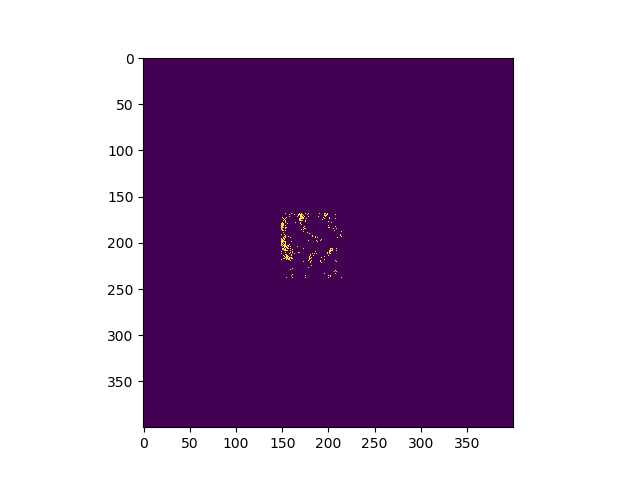

In [377]:
%matplotlib notebook
plt.imshow(new_het[15])

In [366]:
np.sum(het_box)

32018

In [367]:
np.sum(new_het)

32018.0

In [368]:
np.sum(nucCube)

73920

## reversing masked heterochromatin

In [313]:
test_new=new_het.copy()
box_reverse = test_new[::-1,::-1,::-1]
z_axis=np.argmax(box_reverse,axis=0)
t=label(z_axis>0)
props=regionprops(t)
prop=props[0].bbox

x_min = prop[0]
x_max = prop[2]
y_min = prop[1]
y_max = prop[3]

y_axis=np.argmax(box_reverse,axis=2)
t=label(y_axis>0)
props=regionprops(t)
prop=props[0].bbox

z_min = prop[0]
z_max = prop[2]

In [314]:
new_box=box_reverse[z_min:z_max, x_min:x_max, y_min:y_max]

In [378]:
box_reverse.shape

(45, 400, 400)

In [363]:
new_box.shape

(16, 70, 66)

In [365]:
16*70*66

73920

In [364]:
np.sum(new_box)

32018.0

In [376]:
np.sum(new_box)/(16*70*66)

0.4331439393939394

<IPython.core.display.Javascript object>


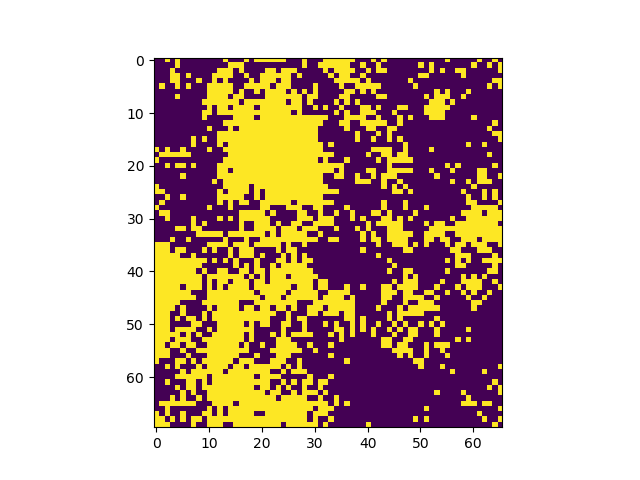

In [371]:
%matplotlib notebook
plt.imshow(het_box[13])

<IPython.core.display.Javascript object>


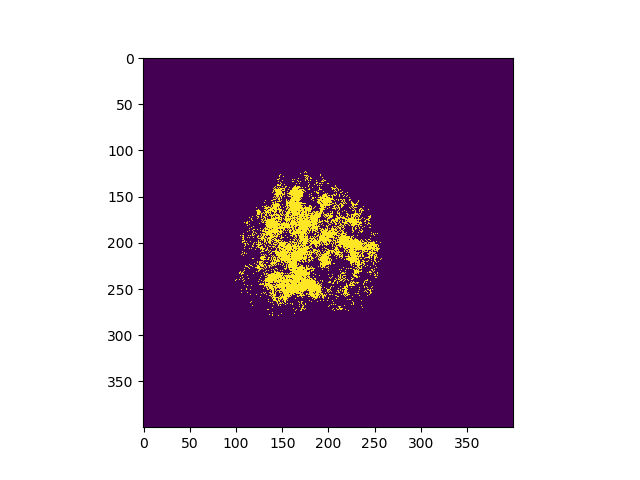

In [372]:
%matplotlib notebook
plt.imshow(het[23])

In [373]:
np.sum(het)

91959

In [374]:
np.sum(nucMask)

459898

In [375]:
np.sum(het)/np.sum(nucMask)

0.19995520745904527

<IPython.core.display.Javascript object>


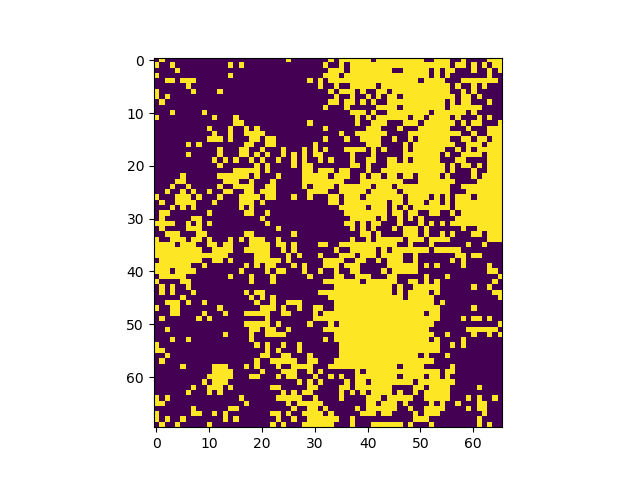

In [369]:
%matplotlib notebook
plt.imshow(new_box[2])

## "tiling" heterochromatin box

In [316]:
test_new_box=new_box.copy()

In [338]:
z_rep=int(het.shape[0]/new_box.shape[0])
x_rep=int(het.shape[1]/new_box.shape[1])
y_rep=int(het.shape[2]/new_box.shape[2])

#z_rep=(het.shape[0]/new_box.shape[0])
#x_rep=(het.shape[1]/new_box.shape[1])
#y_rep=(het.shape[2]/new_box.shape[2])

print(z_rep, x_rep, y_rep)


2 5 6


In [339]:
test_final = np.tile(test_new_box, (z_rep, x_rep, y_rep) )

In [357]:
test_final.shape

(32, 350, 396)

<IPython.core.display.Javascript object>


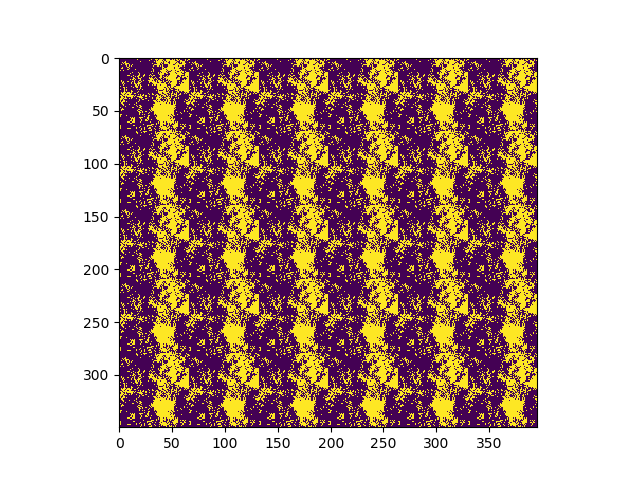

In [358]:
%matplotlib notebook
plt.imshow(test_final[1])

### re-shaping the image 
so that it will have the same shape as the org file
- keeps the egdes empty (as 0)

In [344]:
test_final_final=ma.zeros(nucCube_copy.shape)

In [347]:
test_final_final.shape

(45, 400, 400)

In [346]:
test_final_final[0:test_final.shape[0], 0:test_final.shape[1], 0:test_final.shape[2]]=test_final

<IPython.core.display.Javascript object>


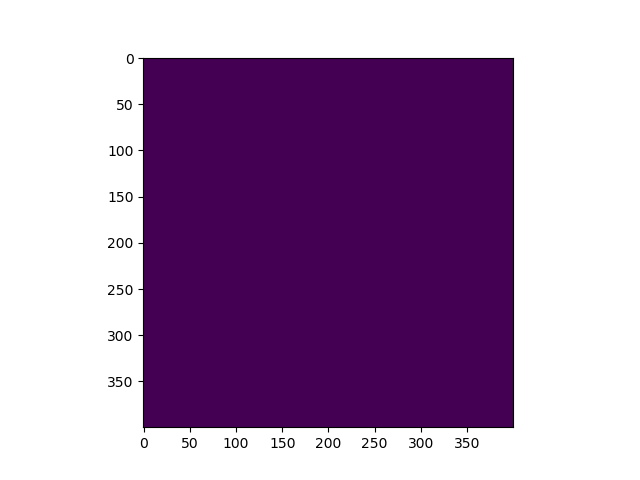

In [361]:
%matplotlib notebook
plt.imshow(test_final_final[33])

In [349]:
nucMask_test=nucMask.copy()

In [353]:
test_final_final=test_final_final.astype(bool)

In [354]:
nucMask_test=nucMask_test.astype(bool)

In [355]:
nucMask_test[test_final_final]=0

<IPython.core.display.Javascript object>


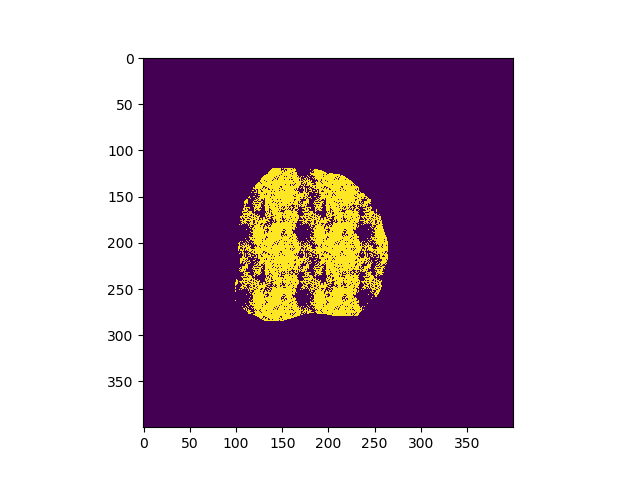

In [356]:
%matplotlib notebook
plt.imshow(nucMask_test[16])